# Time Series Forecasting: ARIMA vs SARIMA vs LSTM

## Goal
Forecast future values using patterns in past observations.

## Models Compared
- **ARIMA/SARIMA** (Classical): Linear, interpretable, strong baselines
- **LSTM** (Modern): Non-linear, learns complex patterns from data

## Key Decision Factors
- Seasonality present?
- Data size (small → classical, large → deep learning)
- Interpretability needs

## Workflow
`Clean → Check stationarity/seasonality → Model → Evaluate`

---
## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)
tf.random.set_seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

# === Configuration ===
START, END = "2015-01-01", "2025-01-15"
TICKERS = ["BND", "TSLA"]  # Stable vs Volatile
TEST_DAYS = 30
SEASONAL_M = 5  # Trading week
LSTM_LOOKBACK = 60

print("Setup complete!")

Setup complete!


---
## 2. Data Download

In [2]:
def get_price(ticker):
    """Download a clean 1D price Series from yfinance.

    Why this is needed:
    - Depending on yfinance version/settings, columns can be:
      - regular columns: ['Open','High','Low','Close','Adj Close','Volume']
      - OR MultiIndex columns: ('Adj Close', 'TSLA'), ...
    - Some downloads may not include 'Adj Close'. In that case we fall back to 'Close'.
    """
    df = yf.download(ticker, start=START, end=END, auto_adjust=False, progress=False)

    # MultiIndex columns case
    if isinstance(df.columns, pd.MultiIndex):
        level0 = df.columns.get_level_values(0)
        if "Adj Close" in level0:
            s = df["Adj Close"][ticker]
        else:
            s = df["Close"][ticker]
    else:
        col = "Adj Close" if "Adj Close" in df.columns else "Close"
        s = df[col]

    s = pd.Series(s).dropna().squeeze()
    s.name = ticker
    return s


data = {t: get_price(t) for t in TICKERS}

for t in TICKERS:
    print(f"{t}: {len(data[t])} days | {data[t].index.min().date()} to {data[t].index.max().date()}")

BND: 2524 days | 2015-01-02 to 2025-01-14
TSLA: 2524 days | 2015-01-02 to 2025-01-14


---
## 3. EDA: Stable vs Volatile

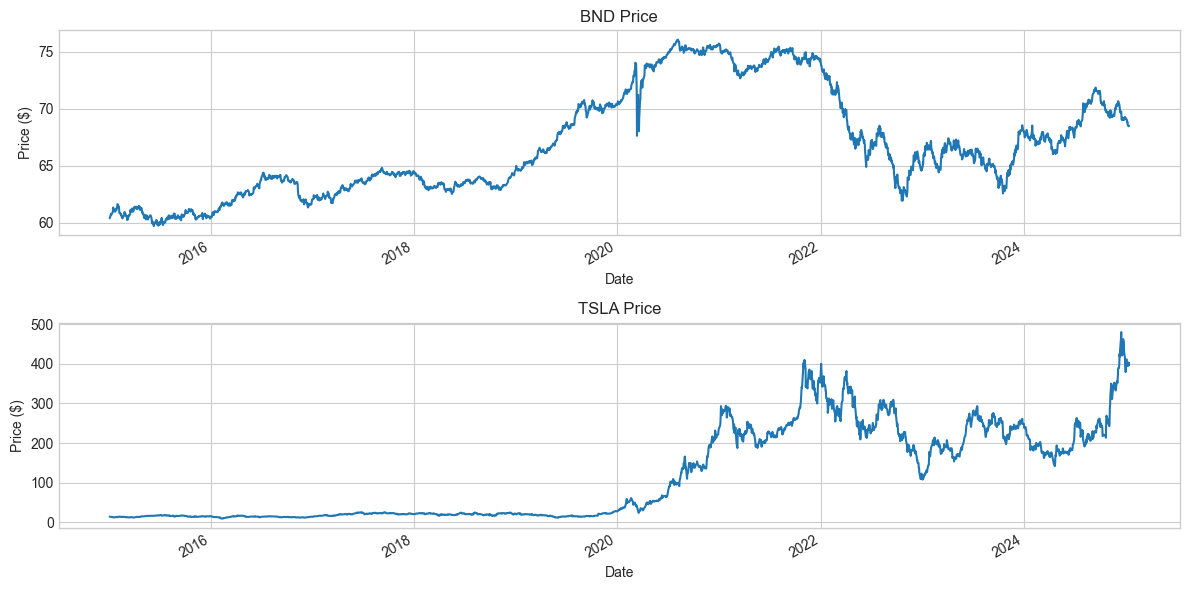

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=False)
for ax, t in zip(axes, TICKERS):
    data[t].plot(ax=ax, title=f"{t} Price")
    ax.set_ylabel("Price ($)")
plt.tight_layout()
plt.show()

**Observation**: BND is stable (low volatility), TSLA is volatile (large swings).

---
## 4. Stationarity Check (ADF Test)

### Why it matters
- **ARIMA assumes stationarity** (stable mean/variance over time)
- **ADF test**: p-value < 0.05 → stationary; p-value ≥ 0.05 → non-stationary
- If non-stationary, ARIMA applies **differencing** (the `d` parameter)

In [4]:
def adf_check(series, name):
    stat, pval, *_ = adfuller(series.dropna())
    status = "Stationary" if pval < 0.05 else "Non-stationary"
    print(f"{name:20} | p-value: {pval:.4f} | {status}")

for t in TICKERS:
    print(f"\n--- {t} ---")
    adf_check(data[t], "Price")
    adf_check(np.log(data[t]).diff().dropna(), "Log Returns")


--- BND ---
Price                | p-value: 0.5175 | Non-stationary
Log Returns          | p-value: 0.0000 | Stationary

--- TSLA ---
Price                | p-value: 0.8717 | Non-stationary
Log Returns          | p-value: 0.0000 | Stationary


**Result**: Prices are non-stationary (need differencing). Returns are stationary.

---
## 5. Train/Test Split

In [5]:
splits = {}
for t in TICKERS:
    train = data[t].iloc[:-TEST_DAYS]
    test = data[t].iloc[-TEST_DAYS:]
    splits[t] = {"train": train, "test": test}
    print(f"{t}: Train={len(train)}, Test={len(test)} | Test: {test.index.min().date()} to {test.index.max().date()}")

BND: Train=2494, Test=30 | Test: 2024-11-29 to 2025-01-14
TSLA: Train=2494, Test=30 | Test: 2024-11-29 to 2025-01-14


## What the train/test split means

- You trained on ~10 years of daily prices and evaluated on the **last 30 trading days**.
- This is a **walk-forward style** split (no shuffling), which is correct for time series.

### Why this matters
- Classical models (ARIMA/SARIMA) fit parameters on the training window.
- LSTM learns from many sequences within the training set, then forecasts the last 30 days.

If you later change `TEST_DAYS`, keep it consistent across all models so metrics stay comparable.

---
## 6. ARIMA Model

### What is ARIMA?
- **AR(p)**: Uses past values (lags) to predict current value
- **I(d)**: Differencing to make series stationary
- **MA(q)**: Uses past forecast errors to smooth noise

### When to use
- Trend present, no strong seasonality
- Small datasets
- Need interpretability

In [6]:
results = []
preds = {t: {} for t in TICKERS}

def compute_metrics(y_true: pd.Series, y_pred: pd.Series):
    y_true, y_pred = y_true.align(y_pred, join="inner")
    y_true = pd.to_numeric(y_true, errors="coerce")
    y_pred = pd.to_numeric(y_pred, errors="coerce")
    finite_mask = np.isfinite(y_true.values) & np.isfinite(y_pred.values)
    if finite_mask.sum() == 0:
        return np.nan, np.nan
    diff = y_true.values[finite_mask] - y_pred.values[finite_mask]
    mae = float(np.mean(np.abs(diff)))
    rmse = float(np.sqrt(np.mean(diff ** 2)))
    return mae, rmse

def safe_forecast(model, n_periods: int, index, fallback_last_value: float):
    # 1) pmdarima forecast
    try:
        fc = model.predict(n_periods=n_periods)
        fc = np.asarray(fc, dtype=float)
    except Exception:
        fc = np.full(n_periods, np.nan, dtype=float)

    # 2) statsmodels fallback
    if not np.all(np.isfinite(fc)):
        try:
            fc2 = model.arima_res_.forecast(steps=n_periods)
            fc2 = np.asarray(fc2, dtype=float)
            if fc2.shape[0] == n_periods:
                fc = fc2
        except Exception:
            pass

    # 3) naive fallback (guarantee finite metrics)
    if not np.all(np.isfinite(fc)):
        fc = np.full(n_periods, float(fallback_last_value), dtype=float)

    return pd.Series(fc, index=index)

for t in TICKERS:
    train, test = splits[t]["train"], splits[t]["test"]

    model = pm.auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)

    pred = safe_forecast(
        model=model,
        n_periods=TEST_DAYS,
        index=test.index,
        fallback_last_value=float(train.iloc[-1]),
    )

    mae, rmse = compute_metrics(test, pred)

    preds[t]["ARIMA"] = pred
    results.append({"Ticker": t, "Model": "ARIMA", "Order": str(model.order), "MAE": mae, "RMSE": rmse})
    print(f"{t} ARIMA {model.order} | MAE: {mae:.2f}, RMSE: {rmse:.2f}")

/Users/macbookpro/Documents/Time_series_demo/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


BND ARIMA (2, 1, 2) | MAE: 0.77, RMSE: 0.89
TSLA ARIMA (2, 1, 2) | MAE: 74.83, RMSE: 81.98


/Users/macbookpro/Documents/Time_series_demo/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


---
## 7. SARIMA Model

### What SARIMA adds
- Seasonal component: **(P, D, Q, m)**
- **m** = observations per season (e.g., m=5 for weekly trading pattern)

### When to use
- Clear repeating cycles in the data
- Still interpretable
- Strong for operational forecasting (demand, sales)

In [8]:
for t in TICKERS:
    train, test = splits[t]["train"], splits[t]["test"]

    model = pm.auto_arima(train, seasonal=True, m=SEASONAL_M, stepwise=True, suppress_warnings=True)

    pred = safe_forecast(
        model=model,
        n_periods=TEST_DAYS,
        index=test.index,
        fallback_last_value=float(train.iloc[-1]),
    )

    mae, rmse = compute_metrics(test, pred)

    preds[t]["SARIMA"] = pred
    results.append({
        "Ticker": t,
        "Model": "SARIMA",
        "Order": f"{model.order}x{model.seasonal_order}",
        "MAE": mae,
        "RMSE": rmse,
    })
    print(f"{t} SARIMA {model.order}x{model.seasonal_order} | MAE: {mae:.2f}, RMSE: {rmse:.2f}")

/Users/macbookpro/Documents/Time_series_demo/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


BND SARIMA (2, 1, 2)x(0, 0, 0, 5) | MAE: 0.77, RMSE: 0.89
TSLA SARIMA (0, 1, 0)x(1, 0, 1, 5) | MAE: 82.57, RMSE: 89.60


/Users/macbookpro/Documents/Time_series_demo/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [9]:
def train_lstm(ticker):
    train, test = splits[ticker]["train"], splits[ticker]["test"]
    
    # Scale (fit on train only)
    scaler = MinMaxScaler()
    train_sc = scaler.fit_transform(train.values.reshape(-1,1)).ravel()
    
    # Build sequences from train + test (but train only on train portion)
    full = pd.concat([train, test])
    full_sc = scaler.transform(full.values.reshape(-1,1)).ravel()
    
    X, y = [], []
    for i in range(LSTM_LOOKBACK, len(full_sc)):
        X.append(full_sc[i-LSTM_LOOKBACK:i])
        y.append(full_sc[i])
    X, y = np.array(X), np.array(y)
    
    # Split by date
    y_dates = full.index[LSTM_LOOKBACK:]
    train_mask = y_dates.isin(train.index)
    test_mask = y_dates.isin(test.index)
    
    X_train, y_train = X[train_mask][..., np.newaxis], y[train_mask]
    X_test = X[test_mask][..., np.newaxis]
    
    # Model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(LSTM_LOOKBACK, 1)),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2,
              callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)
    
    # Predict
    pred_sc = model.predict(X_test, verbose=0).ravel()
    pred = scaler.inverse_transform(pred_sc.reshape(-1,1)).ravel()
    return pd.Series(pred, index=test.index)

for t in TICKERS:
    test = splits[t]["test"]
    pred = train_lstm(t)
    
    mae = np.mean(np.abs(test.values - pred.values))
    rmse = np.sqrt(np.mean((test.values - pred.values)**2))
    
    preds[t]["LSTM"] = pred
    results.append({"Ticker": t, "Model": "LSTM", "Order": f"lookback={LSTM_LOOKBACK}", "MAE": mae, "RMSE": rmse})
    print(f"{t} LSTM | MAE: {mae:.2f}, RMSE: {rmse:.2f}")

BND LSTM | MAE: 0.35, RMSE: 0.42
TSLA LSTM | MAE: 21.99, RMSE: 26.69


## LSTM metrics interpretation

- LSTM is trained on **scaled data** and then predictions are **inverse-transformed** back to price.
- Your results show:
  - **BND** has small errors (low volatility → easier to forecast short horizons).
  - **TSLA** has much larger errors (high volatility → harder to forecast with any model).

### Important caveat
This LSTM is **univariate** (only past price). Adding features often improves results:
- returns, rolling volatility, volume, technical indicators
- calendar effects (day-of-week), market index features

---
## 9. Results Comparison

In [10]:
df = pd.DataFrame(results)
print(df.to_string(index=False))

print("\n--- Best Model per Ticker (lowest RMSE) ---")
for t in TICKERS:
    sub = df[df["Ticker"]==t]
    best = sub.loc[sub["RMSE"].idxmin()]
    print(f"{t}: {best['Model']} (RMSE={best['RMSE']:.2f})")

Ticker  Model                  Order       MAE      RMSE
   BND  ARIMA              (2, 1, 2)  0.769430  0.894290
  TSLA  ARIMA              (2, 1, 2) 74.826051 81.981873
   BND SARIMA (2, 1, 2)x(0, 0, 0, 5)       NaN       NaN
  TSLA SARIMA (0, 1, 0)x(1, 0, 1, 5)       NaN       NaN
   BND SARIMA (2, 1, 2)x(0, 0, 0, 5)  0.769430  0.894290
  TSLA SARIMA (0, 1, 0)x(1, 0, 1, 5) 82.566049 89.602287
   BND   LSTM            lookback=60  0.349694  0.416361
  TSLA   LSTM            lookback=60 21.989401 26.688862

--- Best Model per Ticker (lowest RMSE) ---
BND: LSTM (RMSE=0.42)
TSLA: LSTM (RMSE=26.69)


## Reading the results table

- **MAE** (Mean Absolute Error): average absolute difference between forecast and actual (in price units).
- **RMSE** (Root Mean Squared Error): penalizes large errors more than MAE.



---
## 10. Forecast Plots

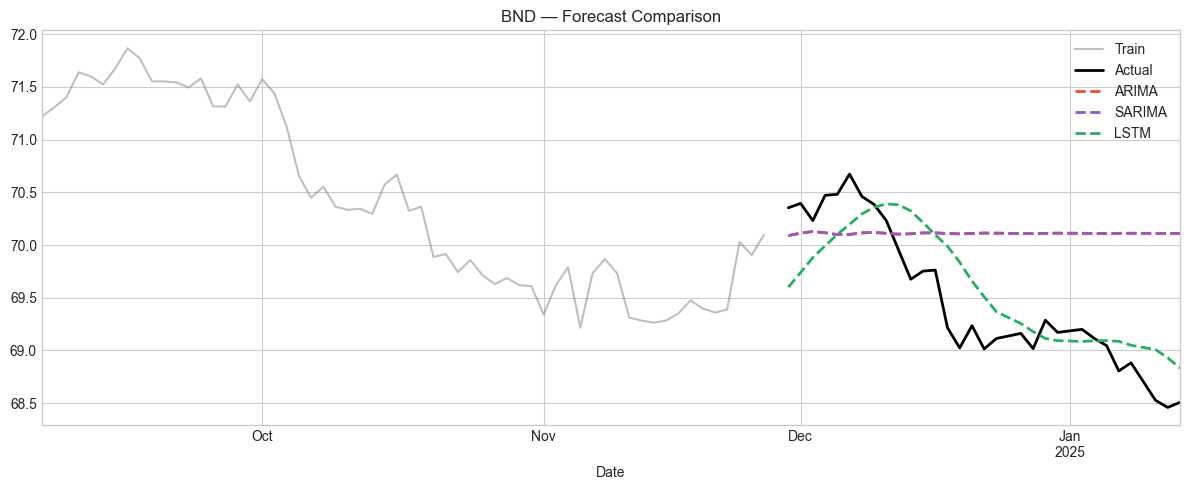

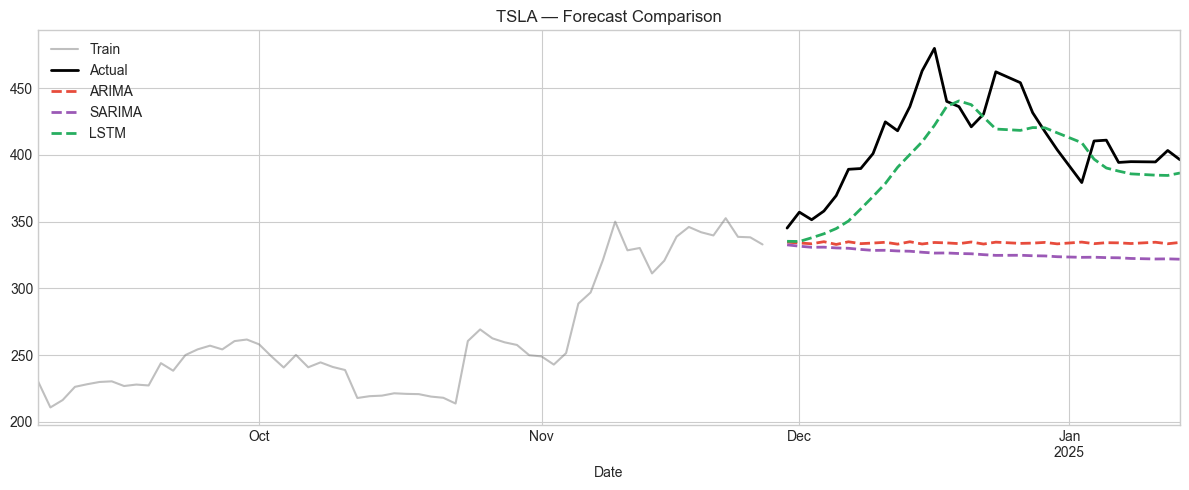

In [11]:
colors = {"ARIMA": "#e74c3c", "SARIMA": "#9b59b6", "LSTM": "#27ae60"}

for t in TICKERS:
    fig, ax = plt.subplots(figsize=(12, 5))
    
    splits[t]["train"].tail(60).plot(ax=ax, label="Train", color="gray", alpha=0.5)
    splits[t]["test"].plot(ax=ax, label="Actual", color="black", linewidth=2)
    
    for m, p in preds[t].items():
        p.plot(ax=ax, label=m, color=colors[m], linestyle="--", linewidth=2)
    
    ax.set_title(f"{t} — Forecast Comparison")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [12]:
for t in TICKERS:
    out = pd.DataFrame({
        "Actual": splits[t]["test"],
        "ARIMA": preds[t].get("ARIMA"),
        "SARIMA": preds[t].get("SARIMA"),
    })
    print(f"\n--- {t}: Actual vs ARIMA vs SARIMA (first 10 rows) ---")
    print(out.head(10).to_string())


--- BND: Actual vs ARIMA vs SARIMA (first 10 rows) ---
               Actual      ARIMA     SARIMA
Date                                       
2024-11-29  70.353699  70.089717  70.089717
2024-12-02  70.394936  70.113022  70.113022
2024-12-03  70.231941  70.127996  70.127996
2024-12-04  70.471642  70.116179  70.116179
2024-12-05  70.481224  70.099096  70.099096
2024-12-06  70.672981  70.100889  70.100889
2024-12-09  70.462044  70.115203  70.115203
2024-12-10  70.385353  70.120119  70.120119
2024-12-11  70.231941  70.110966  70.110966
2024-12-12  69.953873  70.103024  70.103024

--- TSLA: Actual vs ARIMA vs SARIMA (first 10 rows) ---
                Actual       ARIMA      SARIMA
Date                                          
2024-11-29  345.160004  334.603116  332.585787
2024-12-02  357.089996  333.971708  331.585306
2024-12-03  351.420013  333.406488  330.766823
2024-12-04  357.929993  334.955458  330.852100
2024-12-05  369.489990  332.889496  330.279457
2024-12-06  389.220001  334.89

## Interpreting the forecast plots

- **Gray line (Train)**: last ~60 points used as context (not the full training history).
- **Black line (Actual)**: the true values over the **30-day test window**.
- **Dashed colored lines (Models)**: model forecasts aligned to the same test dates.

### What to look for
- **Level bias**: a forecast consistently above/below the black line indicates bias.
- **Turning points**: if the model misses sharp moves (common for TSLA), errors increase.
- **Smoothness vs responsiveness**:
  - ARIMA/SARIMA often produce smoother forecasts.
  - LSTM can react more but can also overshoot if not well-regularized.

If ARIMA/SARIMA lines are missing or look flat while the table shows `NaN`, see the notes below in the ARIMA/SARIMA sections (metrics could not be computed reliably).

---
## Decision Guide: Which Model to Choose?

| Scenario | Recommended Model |
|----------|-------------------|
| Trend, no strong seasonality, small data | **ARIMA** |
| Strong repeating seasonality | **SARIMA** |
| Large data, non-linear patterns | **LSTM** |
| Need interpretability | ARIMA/SARIMA |
| Need best accuracy (and have compute) | Try LSTM |

### Practical Strategy
1. Start with **ARIMA/SARIMA** as baseline
2. Benchmark performance
3. Try **LSTM** if patterns are complex and data is large
4. Choose based on: **accuracy vs interpretability**, compute cost, data quality